# ニューラルネットワークを用いた手書き数字の認識

ニューラルネットワークを用いて手書き数字の認識を行う．

## データのロード

In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

In [2]:
# 訓練データのロード
data = scipy.io.loadmat('data/ex4data1.mat')
# X: 各ピクセルの画素値（特徴量）からなる行ベクトルを全画像について縦に並べた行列
# yl: 正解の数字（ターゲット）を全画像について縦に並べた列ベクトル
X, yl = data['X'], data['y']
yl[yl==10] = 0 # 0の画像のラベルが10に書き換えられているため0に戻す
D, n = X.shape
print('訓練データの数（画像の枚数）：D =',D)
print('特徴量の数（ピクセル数）：n =',n)

訓練データの数（画像の枚数）：D = 5000
特徴量の数（ピクセル数）：n = 400


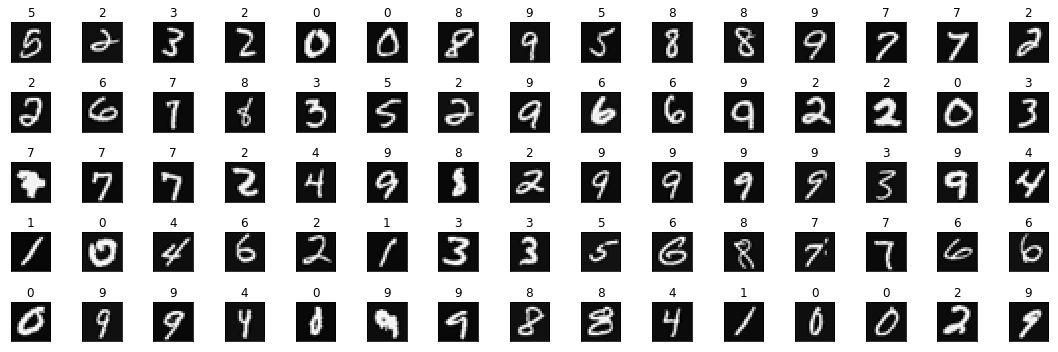

In [4]:
# いくつかの訓練データに対する手書き数字画像と正解数字
n_im_row, n_im_col = 5, 15
n_im = n_im_row * n_im_col
d = np.random.choice(np.arange(D),n_im,replace=False)

n_px_row = np.floor(np.sqrt(n)).astype('int')
n_px_col = (n / n_px_row).astype('int')

fig = plt.figure(figsize=(n_im_col,n_im_row))
gs = gridspec.GridSpec(n_im_row,n_im_col)
k = 0
for i in np.arange(n_im_row):
    for j in np.arange(n_im_col):
        ax = plt.subplot(gs[i,j])
        ax.imshow(X[d[k],:].reshape(n_px_row,n_px_col).T,cmap='gray')
        ax.set_title(str(yl[d[k],-1]))
        ax.tick_params(labelbottom=False,labelleft=False,labelright=False,labeltop=False)
        ax.tick_params(bottom=False,left=False,right=False,top=False)
        k = k + 1

plt.tight_layout()
plt.show()

## 仮説とコスト関数の計算：順伝播

特徴量ベクトルを$\vec{x} =(x_1 ,\dots ,x_n)^\mathrm{T}$，ターゲットの1-hot表現を$\vec{y} =(y_1 ,\dots ,y_C)^\mathrm{T}$とする．1-hot表現$\vec{y}$は$C$次元ベクトルであり，クラスのラベルが$c$ならば$\vec{y}$は第$c$成分のみ1で他が0のベクトルとなる．特徴量$\vec{x}$とターゲット$\vec{y}$は何らかの真の分布$p(\vec{x} ,\vec{y})=p(\vec{x})p(\vec{y} \vert\vec{x})$に従う．

ニューラルネットワークを用いて分布$p(\vec{y} \vert\vec{x})$を推定したい．$L+1$層のニューラルネットワークは次のように与えられる：
\begin{align}
& \vec{a}^{(0)} =\vec{x} , \\
& \left\{
\begin{aligned}
& a_0^{(l)} =1,\quad a^{(l)} =
\begin{pmatrix}
a_0^{(l)} \\
\vec{a}^{(l)}
\end{pmatrix}
, \\
& (\vec{z}^{(l+1)})^\mathrm{T} =(a^{(l)})^\mathrm{T} \Theta ^{(l)} , \\
& \vec{a}^{(l+1)} =\vec{\phi}^{(l+1)} (\vec{z}^{(l+1)})
\end{aligned}
\right.\quad (l=0,\dotsc,L-1), \\
& \vec{h} (\vec{x} \vert\Theta )=\vec{a}^{(L)} .
\end{align}
$l$は層の番号を表し，$l=0$は入力層，$l=1,\dots ,L-1$は隠れ層，$l=L$は出力層である．入力変数は特徴量ベクトル$\vec{x} =(x_1 ,\dots ,x_n)^\mathrm{T}$であり，出力変数は仮説$\vec{h} (\vec{x} \vert\Theta )=(h_1 (\vec{x} \vert\Theta ) ,\dots ,h_C (\vec{x} \vert\Theta ))^\mathrm{T}$である．パラメータ$\Theta$は$L$個の行列（重み）$\Theta ^{(l)}$から成る：$\Theta =(\Theta ^{(l)})_{l=0,1,\dots ,L-1}$. 第$l$層には$n_l$次元変数$\vec{a}^{(l)} =(a_1^{(l)} ,\dots ,a_{n_l}^{(l)})^\mathrm{T}$が割り当てられている．定義から$n_0 =n$, $n_L =C$である．中括弧で括られた漸化式は第$l$層の変数$\vec{a}^{(l)}$から第$l+1$層の変数$\vec{a}^{(l+1)}$への変換を示しており，漸化式を次々に計算する過程は順伝播と呼ばれる．漸化式の第1式は$\vec{a}^{(l)}$に0番目の成分$a_0^{(l)} =1$を加える操作であり，その結果を$a^{(l)}$とする（成分のインデックスが1から始まるベクトルは矢印をつけて表し，インデックスが0から始まるベクトルには矢印をつけない）．第2式は$(n_l +1)\times n_{l+1}$行列$\Theta ^{(l)} =({\Theta ^{(l)\mu}}_j)_{\mu =0,1,\dots ,n_l ;j=1,\dots ,n_{l+1}}$（アルファベット$i,j,\dots$は1から始まる（0を含まない）添字，ギリシャ文字$\mu ,\nu ,\dots$は0から始まる添字とする）をかける線形変換であり，その結果を$\vec{z}^{(l+1)} =(z_1^{(l+1)} ,\dots ,z_{n_{l+1}}^{(l+1)})^\mathrm{T}$とする．第3式は$\vec{z}^{(l+1)}$に活性化関数$\vec{\phi}^{(l+1)} =(\phi _1^{(l+1)} ,\dots ,\phi _{n_{l+1}}^{(l+1)})^\mathrm{T}$を作用させる操作であり，その結果が第$l+1$層の変数$\vec{a}^{(l+1)}$である．隠れ層$l=1,\dots ,L-1$の活性化関数$\vec{\phi}^{(l)}$は成分ごとに作用するシグモイド関数$\sigma$であるとする：
$$
\phi _i^{(l)} (\vec{z})=\sigma (z_i)=\frac{1}{1+e^{-z_i}} .
$$
出力層$l=L$の活性化関数$\vec{\phi}^{(L)}$はソフトマックス関数$\vec{S} =(S_1 ,\dots ,S_C)^\mathrm{T}$とする：
$$
\phi _c^{(L)} (\vec{z})=S_c (\vec{z})=\frac{e^{z_c}}{\sum _{d=1}^C e^{z_d}} .
$$

重みが$\Theta$であるとき，特徴量$\vec{x}$に対してターゲットが$\vec{y}$となる確率が次のように与えられると推定しよう：
$$
p(\vec{y} \vert\vec{x} ,\Theta )=\prod _{c=1}^C h_c (\vec{x} \vert\Theta )^{y_c} .
$$
上式の分布は規格化条件
$$
\sum _{\vec{y} =(1,0,\dots ,0)^\mathrm{T} ,(0,1,0,\dots ,0)^\mathrm{T} ,\dots ,(0,\dots ,0,1)^\mathrm{T}} p(\vec{y} \vert\vec{x} ,\Theta )=1
$$
を満たす．実際には$h_\Theta (\vec{x})$の成分が最も大きくなるようなインデックス$c$がデータの属するクラスであると予測する．

コスト関数$J(\Theta )$は，2つの分布$p(\vec{y} \vert\vec{x})$, $p(\vec{y} \vert\vec{x} ,\Theta )$の条件付きKullback-Leipler (KL) ダイバージェンス
$$
\mathrm{E}_{p(\vec{x} ,\vec{y})} \left[\log\frac{p(\vec{y} \vert\vec{x})}{p(\vec{y} \vert\vec{x} ,\Theta )} \right] =\mathrm{E}_{p(\vec{x} ,\vec{y})} [\log p(\vec{y} \vert\vec{x})]-\mathrm{E}_{p(\vec{x} ,\vec{y})} [\log p(\vec{y} \vert\vec{x} ,\Theta )]
$$
から第1項の定数を除いたもの，すなわち交差エントロピーとする：
$$
J(\Theta )=-\mathrm{E}_{p(\vec{x} ,\vec{y})} [\log p(\vec{y} \vert\vec{x} ,\Theta )]=-\mathrm{E}_{p(\vec{x} ,\vec{y})} \left[\sum _{c=1}^C y_c \log h_c (\vec{x} \vert\Theta )\right] .
$$

## コスト関数の勾配計算：誤差逆伝播法

次にコスト関数の勾配
$$
\frac{\partial J(\Theta )}{\partial {\Theta ^{(l)\mu}}_j} =\mathrm{E}_{p(\vec{x} ,\vec{y})} \left[\frac{\partial}{\partial {(\Theta ^{(l)})^\mu}_j} (-\log p(\vec{y} \vert\vec{x} ,\Theta ))\right]
$$
を求めよう．偏微分の連鎖率を用いると，対数尤度関数の勾配は次のように表される：
$$
\frac{\partial}{\partial {\Theta ^{(l)\mu}}_j} (-\log p(\vec{y} \vert\vec{x} ,\Theta ))=\frac{\partial z_{j_{l+1}}^{(l+1)}}{\partial {\Theta ^{(l)\mu}}_j} \left(\prod _{l'=l+1}^{L-1} \frac{\partial a_{i_{l'}}^{(l')}}{\partial z_{j_{l'}}^{(l')}} \frac{\partial z_{j_{l'+1}}^{(l'+1)}}{\partial a_{i_{l'}}^{(l')}} \right)\frac{\partial a_{i_L}^{(L)}}{\partial z_{j_L}^{(L)}} \frac{\partial}{\partial a_{i_L}^{(L)}} (-\log p(\vec{y} \vert\vec{x} ,\Theta )).
$$
ただし，$l'=l+1,\dots ,L-1$に関する積は$l=L-1$のとき1とする．また，2回繰り返された添字（上式では$i_{l+1} \dots ,i_L$, $j_{l+1} ,\dots ,j_L$）について和をとるEinsteinの縮約規則を用いた．ここで
$$
\delta ^{(l+1)j_{l+1}} =\frac{\partial}{\partial z_{j_{l+1}}^{(l+1)}} (-\log p(\vec{y} \vert\vec{x} ,\Theta ))=\left(\prod _{l'=l+1}^{L-1} \frac{\partial a_{i_{l'}}^{(l')}}{\partial z_{j_{l'}}^{(l')}} \frac{\partial z_{j_{l'+1}}^{(l'+1)}}{\partial a_{i_{l'}}^{(l')}} \right)\frac{\partial a_{i_L}^{(L)}}{\partial z_{j_L}^{(L)}} \frac{\partial}{\partial a_{i_L}^{(L)}} (-\log p(\vec{y} \vert\vec{x} ,\Theta ))
$$
とおくと，次式が得られる：
$$
\frac{\partial}{\partial {\Theta ^{(l)\mu}}_j} (-\log p(\vec{y} \vert\vec{x} ,\Theta ))=\frac{\partial z_{j_{l+1}}^{(l+1)}}{\partial {\Theta ^{(l)\mu}}_j} \delta ^{(l+1)j_{l+1}} =a_\mu ^{(l)} \delta ^{(l+1)j} .
$$

$\vec{\delta}^{(l)} =(\delta ^{(l)1} ,\dots ,\delta ^{(l)n_l})^\mathrm{T}$ ($l=1,\dots ,L$) は「誤差」と呼ばれる．出力層$l=L$の誤差ベクトル$\vec{\delta}^{(L)}$は仮説とターゲットの差となる：
\begin{align}
\delta ^{(L)c} & =\frac{\partial}{\partial z_c^{(L)}} (-\log p(\vec{y} \vert\vec{x} ,\Theta ))=\frac{\partial a_{c'}^{(L)}}{\partial z_c^{(L)}} \frac{\partial}{\partial a_{c'}^{(L)}} (-\log p(\vec{y} \vert\vec{x} ,\Theta )) \\
& =-\sum _{c'=1}^C \frac{y_{c'}}{a_{c'}^{(L)}} a_{c'}^{(L)} (\delta _{c'c} -a_c^{(L)})=\sum _{c'=1}^C y_{c'} (a_c^{(L)} -\delta _{c'c}) \\
& =a_c^{(L)} -y_c \\
\iff\vec{\delta}^{(L)} & =\vec{a}^{(L)} -\vec{y} .
\end{align}
ここでKroneckerのデルタを$\delta _{c'c}$と書いた．また，隠れ層$l=1,\dots ,L-1$の誤差ベクトル$\vec{\delta}^{(l)}$は次の漸化式から計算できる：
$$
\delta ^{(l)j_l} =\frac{\partial a_{i_l}^{(l)}}{\partial z_{j_l}^{(l)}} \frac{\partial z_{j_{l+1}}^{(l+1)}}{\partial a_{i_l}^{(l)}} \delta ^{(l+1)j_{l+1}} =\frac{\partial\phi _{i_l}^{(l)} (\vec{z}^{(l)})}{\partial z_{j_l}^{(l)}} {\Theta ^{(l)i_l}}_{j_{l+1}} \delta ^{(l+1)j_{l+1}} \iff\vec{\delta}^{(l)} =\sigma '(\vec{z}^{(l)})*(\tilde{\Theta}^{(l)} \vec{\delta} ^{(l+1)}).
$$
ここで，$\sigma '(\vec{z}^{(l)})$は$\vec{z}^{(l)}$の各成分を引数に持つシグモイド関数$\sigma$の導関数であり，シグモイド関数$\sigma$の導関数は次のように与えられる：
$$
\sigma '(z)=\sigma (z)(1-\sigma (z)).
$$
また，$\tilde{\Theta}^{(l)} =({\Theta ^{(l)i}}_j)_{i=1,\dots ,n_l;j=1,\dots ,n_{l+1}}$は$\Theta ^{(l)}$から第0行を除いて得られる行列であり，$*$はベクトルの成分ごとの積を表す．

以上で導いた式を用いてコスト関数の勾配を計算することができる．上の$\vec{\delta}^{(l)}$に関する漸化式は誤差を出力層から入力に近い層に向かって逆に伝播させる過程と見なせるため，逆伝播と呼ばれる．また，このように誤差やコスト関数の勾配を求める方法は誤差逆伝播法と呼ばれる．

## 正則化および最大事後確率推定との関係

実際の計算では真の分布$p(x,y)$がわからないため，期待値$\mathrm{E}_{p(x,y)} [\cdot ]$は訓練データに関する平均値に置き換える：
\begin{align}
J(\Theta ) & =-\frac{1}{D} \sum _{d=1}^D \log p(\vec{y}^{[d]} \vert\vec{x}^{[d]} ,\Theta ), \\
\frac{\partial J(\Theta )}{\partial {\Theta ^{(l)\mu}}_j} & =-\frac{1}{D} \sum _{d=1}^D \frac{\partial}{\partial {\Theta ^{(l)\mu}}_j} \log p(\vec{y}^{[d]} \vert\vec{x}^{[d]} ,\Theta ).
\end{align}
ここで，$[d]$ ($d=1,\dots ,D$) は訓練データのインデックスを表す．

正則化を行う場合，コスト関数とその勾配は次のように表される：
\begin{align}
J_\mathrm{r} (\Theta ) & =J(\Theta )+\frac{1}{2D} \sum _{l=0}^{L-1} \sum _{\mu =0}^{n_l} \sum _{j=1}^{n_{l+1}} {M^{(l)\mu}}_j ({\Theta ^{(l)\mu}}_j)^2 , \\
\frac{\partial J_\mathrm{r} (\Theta )}{\partial {\Theta ^{(l)\mu}}_j} & =\frac{\partial J(\Theta )}{\partial {\Theta ^{(l)\mu}}_j} +\frac{1}{D} {M^{(l)\mu}}_j {\Theta ^{(l)\mu}}_j .
\end{align}
正則化パラメータ$M=(M^{(l)})_{l=0,1,\dots ,L-1} =({M^{(l)\mu}}_j)_{l=0,1,\dots ,L-1;\mu =0,1,\dots ,n_l ;j=1,\dots ,n_{l+1}}$はハイパーパラメータである．正則化項をつけたコスト関数$J_\mathrm{r} (\Theta )$の最小化は，与えられたデータ$\{ (\vec{x}^{[d]} ,\vec{y}^{[d]})\} _{d=1,\dots ,D}$とハイパーパラメータ$M$に対して事後分布$p(\Theta\vert\{ (\vec{x}^{[d]} ,\vec{y}^{[d]})\} ,M)$を最大化するパラメータ$\Theta$の推定，すなわち最大事後確率推定と見なせる．実際，各データが独立同分布$p(\vec{x} ,\vec{y})$に従って生成されると仮定すると，
$$
p(\Theta\vert\{ (\vec{x}^{[d]} ,\vec{y}^{[d]})\} ,M)=\frac{p(\{ (\vec{x}^{[d]} ,\vec{y}^{[d]})\} ,\Theta\vert M)}{p(\{ (\vec{x}^{[d]} ,\vec{y}^{[d]})\} )}
$$
および
$$
p(\{ (\vec{x}^{[d]} ,\vec{y}^{[d]})\} ,\Theta\vert M)=p(\Theta\vert M)p(\{ (\vec{x}^{[d]} ,\vec{y}^{[d]})\} \vert\Theta )=p(\Theta\vert M)\prod _{d=1}^D p(\vec{x}^{[d]} ,\vec{y}^{[d]} \vert\Theta )
$$
が成り立つので，ハイパーパラメータ$M$に対するパラメータ$\Theta$の分布を正規分布
$$
p(\Theta\vert M)=\prod _{l=0}^{L-1} \prod _{\mu =0}^{n_l} \prod _{j=1}^{n_{l+1}} \sqrt{\frac{{M^{(l)\mu}}_j}{2\pi}} \exp\left( -\frac{1}{2} {M^{(l)\mu}}_j ({\Theta ^{(l)\mu}}_j)^2 \right)
$$
とすると，
$$
\mathop{\mathrm{arg\, max}}_\Theta p(\Theta\vert\{ (\vec{x}^{[d]} ,\vec{y}^{[d]})\} ,M)=\mathop{\mathrm{arg\, max}}_\Theta J_\mathrm{r} (\Theta )
$$
が導かれる．なお，正則化なしのコスト関数の最小化は尤度関数$p(\{ (\vec{x}^{[d]} ,\vec{y}^{[d]})\}\vert\Theta )$を最大化するパラメータ$\Theta$の推定，すなわち最尤推定と見なせる：
$$
\mathop{\mathrm{arg\, max}}_\Theta p(\{ (\vec{x}^{[d]} ,\vec{y}^{[d]})\}\vert\Theta )=\mathop{\mathrm{arg\, max}}_\Theta J(\Theta ).
$$

以下では正則化パラメータを${M^{(l)0}}_j =0$, ${M^{(l)i}}_j =\mu$と定める（今まで通り$i$は1以上の添字を表す）．

## Fisher計量

\begin{align}
& \vec{a}^{(0)} =\vec{x} , \\
& \left\{
\begin{aligned}
& a_0^{(l)} =1,\quad a^{(l)} =
\begin{pmatrix}
a_0^{(l)} \\
\vec{a}^{(l)}
\end{pmatrix}
, \\
& (\vec{z}^{(l+1)})^\mathrm{T} =(a^{(l)})^\mathrm{T} \Theta ^{(l)} , \\
& \vec{a}^{(l+1)} =\vec{\phi}^{(l+1)} (\vec{z}^{(l+1)})
\end{aligned}
\right.\quad (l=0,\dotsc,L-1), \\
& \vec{h} (\vec{x} \vert\Theta )=\vec{a}^{(L)} .
\end{align}

$$
{t^{(l)j_l}}_{j_{l+1}} =\frac{\partial\phi _{i_l}^{(l)} (\vec{z}^{(l)})}{\partial z_{j_l}^{(l)}} {\Theta ^{(l)i_l}}_{j_{l+1}}
$$

$l'\geq l$とする．
$$
\delta ^{(l+1)j_{l+1}} =\left(\prod _{m=l+1}^{L-1} {t^{(m)j_m}}_{j_{m+1}} \right)\delta ^{(L)j_L} =\left(\prod _{m=l+1}^{l'} {t^{(m)j_m}}_{j_{m+1}} \right)\left(\prod _{m=l'+1}^{L-1} {t^{(m)j_m}}_{j_{m+1}} \right)\delta ^{(L)j_L}
$$
より
$$
\frac{\partial\delta ^{(l+1)j_{l+1}}}{\partial {\Theta ^{(l')\mu}}_j} =\left(\prod _{m=l+1}^{l'} {t^{(m)j_m}}_{j_{m+1}} \right)\left[\sum _{l''=l'+1}^{L-1} \frac{\partial {t^{(l'')j_{l''}}}_{j_{l''+1}}}{\partial {\Theta ^{(l')\mu}}_j} \left(\prod _{\substack{m=l'+1\\ m\not= l''}}^{L-1} {t^{(m)j_m}}_{j_{m+1}} \right)\delta ^{(L)j_L} +\left(\prod _{m=l'+1}^{L-1} {t^{(m)j_m}}_{j_{m+1}} \right)\frac{\partial\delta ^{(L)j_L}}{\partial {\Theta ^{(l')\mu}}_j} \right]
$$

$$
\frac{\partial {t^{(l'')j_{l''}}}_{j_{l''+1}}}{\partial {\Theta ^{(l')\mu}}_j} =\frac{\partial z_{k_{l''}}^{(l'')}}{\partial {\Theta ^{(l')\mu}}_j} \frac{\partial ^2 \phi _{i_{l''}}^{(l'')} (\vec{z}^{(l'')})}{\partial z_{j_{l''}}^{(l'')} \partial z_{k_{l''}}^{(l'')}} {\Theta ^{(l'')i_{l''}}}_{j_{l''+1}} ,\quad\frac{\partial z_{j_{l''}}^{(l'')}}{\partial {\Theta ^{(l')\mu}}_j} =a_\mu ^{(l')} \delta _{j_{l'+1}}^j \prod _{m=l'+1}^{l''-1} {t^{(m)j_m}}_{j_{m+1}} \quad (l''\geq l'+1)
$$

$$
\frac{\partial\delta ^{(L)c}}{\partial {\Theta ^{(l')\mu}}_j} =\frac{\partial z_{c'}^{(L)}}{\partial {\Theta ^{(l')\mu}}_j} \frac{\partial\delta ^{(L)c}}{\partial z_{c'}^{(L)}}
$$
$$
H^{cc'} :=\frac{\partial\delta ^{(L)c}}{\partial z_{c'}^{(L)}} =a_c^{(L)} \delta _{cc'} -a_c^{(L)} a_{c'}^{(L)}
$$

$$
\frac{\partial}{\partial {\Theta ^{(l)\mu}}_j \partial {\Theta ^{(l')\nu}}_k} (-\log p(\vec{y} \vert\vec{x} ,\Theta ))=a_\mu ^{(l)} \frac{\partial\delta ^{(l+1)j}}{\partial {\Theta ^{(l')\nu}}_k}
$$

$\mathrm{E}_{p(\vec{y} \vert\vec{x} ,\Theta )} [\vec{\delta}^{(L)}]=\vec{0}$より
\begin{align}
g_{\mu\nu}^{(l,l')jk} & =\mathrm{E}_{p(\vec{x} ,\vec{y} \vert\Theta )} \left[\frac{\partial}{\partial {\Theta ^{(l)\mu}}_j \partial {\Theta ^{(l')\nu}}_k} (-\log p(\vec{y} \vert\vec{x} ,\Theta ))\right] \\
& =\mathrm{E}_{p(\vec{x})} \left[ a_\mu ^{(l)} a_\nu ^{(l')} H^{j_L k_L} {t^{(l+1)j}}_{j_{l+2}} {t^{(l+2)j_{l+2}}}_{j_{l+3}} \cdots {t^{(L-1)j_{L-1}}}_{j_L} {t^{(l'+1)k}}_{k_{l'+2}} {t^{(l'+2)k_{l'+2}}}_{k_{l'+3}} \cdots {t^{(L-1)k_{L-1}}}_{k_L} \right]
\end{align}

$$
{T^{(l\to l')j_l}}_{j_{l'}} = {t^{(l)j_l}}_{j_{l+1}} \cdots {t^{(l'-1)j_{l'-1}}}_{j_{l'}}
$$
とおく．

$$
\delta ^{(l+1)j} = {T^{(l+1\to L)j}}_c \delta ^{(L)c}
$$

$$
\frac{\partial}{\partial {\Theta ^{(l)\mu}}_j} (-\log p(\vec{y} \vert\vec{x} ,\Theta ))=a_\mu ^{(l)} \delta ^{(l+1)j} =a_\mu ^{(l)} \delta ^{(L)c} {T^{(l+1\to L)j}}_c .
$$

$$
g_{\mu\nu}^{(l,l')jk} =\mathrm{E}_{p(\vec{x})} \left[ a_\mu ^{(l)} a_\nu ^{(l')} H^{cc'} {T^{(l+1\to L)j}}_c {T^{(l'+1\to L)k}}_{c'} \right]
$$

In [5]:
# ターゲットの1-hot表現
C = 10 # クラス数（0から9までの10クラス）
Y = np.zeros((D,C))
Y[np.arange(D),yl.flatten()] = 1

In [6]:
# 各層のサイズ
n1 = 25
layer_size = [n,n1,C]

In [7]:
# 重み行列のベクトル化
def mats2vec(A):
    A_v = np.array([])
    for A_l in A:
        A_v = np.append(A_v,A_l)
    return(A_v)

In [8]:
# ベクトル化されたパラメータから重み行列への変換
def vec2mats(A_v,layer_size):
    L = len(layer_size) - 1
    A = []
    N_l = 0
    for l in range(L):
        n_l = layer_size[l]
        n_lp1 = layer_size[l+1]
        N_lp1 = N_l + (n_l+1) * n_lp1
        A_l = A_v[N_l:N_lp1].reshape(n_l+1,n_lp1)
        A.append(A_l)
        N_l = N_lp1
    return(A)

In [9]:
# 行列の左にすべての成分が1の列を挿入する関数
def insert1column(A):
    A_ext = np.insert(A,0,1,axis=1)
    return(A_ext)

In [10]:
# アフィン変換
def affine(A,Theta):
    A_ext = insert1column(A)
    Z = A_ext @ Theta
    return(Z)

In [23]:
# 順伝播と逆伝播
def propagation(Theta_v,layer_size,X,phi_hid,phi_out,propdir='fb'):
    Theta = vec2mats(Theta_v,layer_size)
    Theta0 = Theta[0]
    Theta1 = Theta[1]
    
    A0 = X
    Z1 = affine(A0,Theta0)
    A1, A1_Z1 = phi_hid(Z1)
    Z2 = affine(A1,Theta1)
    A2, A2_Z2 = phi_out(Z2)
    A = [A0,A1,A2]
    Z = [Z1,Z2]
    vardict = {'mainvar':A, 'intrvar':Z, 'gradout':A2_Z2}
    
    if propdir == 'fb':
        t1 = np.einsum('di,ij->dij',A1_Z1,Theta1[1:,:])
        T2_2 = np.tile(np.eye(layer_size[-1]),(X.shape[0],1,1))
        T1_2 = np.einsum('dij,djk->dik',t1,T2_2)
        t = [t1]
        T = [T1_2,T2_2]
        vardict['transfm'] = t
        vardict['cumtrfm'] = T
        return(vardict)
    elif propdir == 'f':
        return(vardict)
    else:
        raise ValueError('invalid propdir')

In [18]:
# ソフトマックス関数とその勾配行列
def softmax_gradient(z):
    z -= np.amax(z,axis=1).reshape(-1,1)
    exp_z = np.exp(z)
    sum_exp_z = np.sum(exp_z,axis=1).reshape(-1,1)
    s = exp_z / sum_exp_z
    e = np.eye(s.shape[1])
    s_z = np.einsum('di,ij->dij',s,e) - np.einsum('di,dj->dij',s,s)
    return(s,s_z)

In [22]:
# ソフトマックス出力関数に対応するコスト関数とその勾配
def costFunction_gradient(Theta_v,layer_size,X,Y,phi_hid,propdir='fb'):
    epsilon = 1e-7 # np.log(0) の発散を防ぐ
    
    phi_out = softmax_gradient
    vardict = propagation(Theta_v,layer_size,X,phi_hid,phi_out,propdir)
    A = vardict['mainvar']
    h = A[-1]
    D = X.shape[0]
    J = -(1 / D) * np.sum(Y * np.log(h + epsilon))
    
    if propdir == 'fb':
        T = vardict['cumtrfm']
        L = len(layer_size) - 1
        J_Theta = []
        Delta_L = h - Y
        for l in range(L):
            A_l = A[l]
            A_l_ext = insert1column(A_l)
            T_lp1_L = T[l]
            Delta_lp1 = np.einsum('dij,dj->di',T_lp1_L,Delta_L)
            J_Theta_l = (1 / D) * A_l_ext.T @ Delta_lp1
            J_Theta.append(J_Theta_l)
        J_Theta_v = mats2vec(J_Theta)
        return(J,J_Theta_v,vardict)
    elif propdir == 'f':
        return(J,vardict)
    else:
        raise ValueError('invalid propdir')

In [ ]:
# Fisher計量
def FisherMetric(A,T,grad_h):
    D = grad_h.shape[0]
    G = np.
    for l in range(L):
        A_l = A[l]
        n_l = A_l.shape[1]
        A_l_ext = insert1column(A_l)
        T_lp1_L = T[l]
        n_lp1 = T_lp1_L.shape[1]
        G_ll = (1 / D) * np.einsum('da,db,dik,djl,dkl->aibj',A_l_ext,A_l_ext,T_lp1_L,T_lp1_L,grad_h)
        nrows_G_ll_m = (n_l+1) * n_lp1
        G_ll_m = G_ll.reshape(nrows_G_ll_m,nrows_G_ll_m)
        
    for l in range(L):
        for m in range(L):
            

In [25]:
a = np.array([5,7,4])
b = np.arange(24).reshape(3,8)
np.append(a,b)

array([ 5,  7,  4,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,
       14, 15, 16, 17, 18, 19, 20, 21, 22, 23])

In [28]:
c = np.array([])
np.stack(c,b)

ValueError: need at least one array to stack